In [3]:
# importing all the libraries needed for face detection
import cv2 
import os 
import random 
import numpy as np
from matplotlib import pyplot as plt

#plt.imshow is used to dispaly data as image which is used for facial detection

IMPORTING TENSORFLOW DEPENDENCIES 
WE WILL USE TENSORFLOW FUNCTIONAL API, CASUE IT IS FLEXIBLE AND CAN HELP US DETECT IF 2 IMAGES ARE SIMILAR OR NOT. 

layers - 
1. Dense: used to connect layers
2. Conv2d: helps in performing convolution 
3. MaxPooling2D: helps in pooling data and shrink the data we received
4. Input: defines what we are passing through the model
5. Flatten: takes info from previous layers and flattens them into 1 dimension 

In [4]:
#importing tensorflow dependencies- FUNTIONAL API 
from tensorflow.keras.models import Model #implementing layers
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #different types of layers 
import tensorflow as tf

SETTING GPU GROWTH 

In [6]:
#avoid out of memory issue/error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

SETUP FOLDERS

In [3]:
#Setup paths
pos_path= os.path.join('data', 'positive')  
neg_path= os.path.join('data', 'negative')
anc_path= os.path.join('data', 'anchor')

MAKING THE DIRECTORY        

In [4]:
#make directory
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

ANCHOR - WEBCAM(opencv)
POSITIVE- WEBCAM
NEGATIVE- labelled faces in the wild dataset

In [5]:
#Move the lfwdeepfunneled images to negative folder
for directory in os.listdir('face/lfw-deepfunneled/lfw-deepfunneled'): 
    for file in os.listdir(os.path.join('face/lfw-deepfunneled/lfw-deepfunneled', directory)):
        ex_path = os.path.join('face/lfw-deepfunneled/lfw-deepfunneled', directory, file)
        new_path= os.path.join(neg_path, file)
        os.replace(ex_path, new_path)

In [6]:
#importing uuid library to generate unique image names
import uuid

POSITIVE AND ANCHOR IMAGES

In [7]:
#Establish the connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    #cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #creating a unique file path
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor image
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #creating a unique file path
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor image
        cv2.imwrite(imgname, frame)
        
   #show image back to screen 
    cv2.imshow('Image Collection ', frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
# close the image show frame
cv2.destroyAllWindows()

In [1]:
#plt.imshow(frame)

DATA AUGMENTATION

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower = 0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_crop(img,size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality = 90,max_jpeg_quality = 100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower = 0.9, upper = 1, seed =(np.random.randint(100), np.random.randint(100)))
        
        data.append(img)
    return data

This might not be necessary casue we have already declared all the libraries to be used in the starting. 
After adding the code block for Data Augmentation, it was casuing an issue while running the code that is why all the libraries had to be redeclared. 

In [9]:
import os
import uuid
import cv2
import tensorflow as tf
import numpy as np

In [10]:
for file_name in os.listdir(os.path.join(pos_path)):
    img_path = os.path.join(pos_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for img in augmented_images:
        cv2.imwrite(os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1())), img.numpy())

In [11]:
for file_name in os.listdir(os.path.join(anc_path)):
    img_path = os.path.join(anc_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for img in augmented_images:
        cv2.imwrite(os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1())), img.numpy())

GETTING THE IMAGE DIRECTORIES   

In [12]:
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(3000)

PREPROCESSING

In [13]:
def preprocessing(filepath):
    #read in image from the file path
    byte_img = tf.io.read_file(filepath)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps-resizing the image to 100x100x3
    img = tf.image.resize(img, (100,100))
    #scaling the image b/w 0 and 1 
    img = img/255.0
    
    #returning the image
    return img

CREATING LABELLED DATASET

In [14]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positives.concatenate(negatives)

In [15]:
# ITERATING THROUGH THE ANCHOR AND POSTIVE FOLDER AT RANDOM AND CHECKING IF THE RESULT IS 1 OR 0
"""
samples = data.as_numpy_iterator()
samples.next()"""

'\nsamples = data.as_numpy_iterator()\nsamples.next()'

BUILD TRAN AND TESST PARTITION

In [17]:
def preprocess_twin(input_img, validation_img, label): 
    return preprocessing(input_img), preprocessing(validation_img), label

In [18]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#to get mixed set of samples
data = data.shuffle(buffer_size = 10000)

In [19]:
# TESTING
"""sample = data.as_numpy_iterator()
samp = sample.next()
plt.imshow(sample.next()[1])
plt.imshow(sample.next()[0])
samp[2]"""

'sample = data.as_numpy_iterator()\nsamp = sample.next()\nplt.imshow(sample.next()[1])\nplt.imshow(sample.next()[0])\nsamp[2]'

TRAINING PATITION   

In [20]:
# training partition 
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

TESTING PARTITION   

In [21]:
#testing partition
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

BUILDING A SIAMESE NERUAL NETWORK
1. build the embedding layers
2. build the distance layer
3. make the siamese model

In [22]:
from tensorflow.keras.models import Model #implementing layers
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 

In [23]:
# building embedding layer
# all the values taken here are according to the siamese model paper
def make_embedding(): 
    inp = Input(shape= (100,100,3), name = 'input_image')
    
    #First block
    c1 = Conv2D(64,(10,10), activation= 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    #Second block
    c2 = Conv2D(128,(7,7), activation= 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    
    #Third block
    c3 = Conv2D(128,(4,4), activation= 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    #Fourth block 
    c4 = Conv2D(256,(4,4), activation= 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs =[inp] , outputs =[d1], name='embedding')

In [24]:
#Create an instance of the embedding model
embedding_model = make_embedding()
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#build siamese L1 distance class
class L1Dist(Layer): 
    #performing inheritance - init method
    def __init__(self, **kwargs):
        super().__init__()
        
    #similarity calculation
    def call(self, input_embedding, validation_embedding):
        #making other change if this doesn't work then revert back to original
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)
       # return tf.math.abs(input_embedding - validation_embedding)

In [26]:
#Siamese model
def make_siamese_model(): 
    
    #handle inputs
    #anchor image in the network
    input_image = Input(name = "input_img", shape=(100,100,3))
    
    #validation image in the network 
    validation_image = Input(name = 'validation_img', shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    
    #classification layer 
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs =[input_image, validation_image], outputs= classifier, name ='Siamese')

In [27]:
siamese_model = make_siamese_model()

TRAINING THE SIAMESE NEURAL NETWORK
1. loss and optimizer
2. checkpoints
3. train step functiion - tells us what happens when we train on a single batch 
4. training loop 
5. train the model

In [28]:
# loss function and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)


In [29]:
#checkpoint callback
checkpoint_dir = './training_checkpoints'
checkpoints_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt= opt, siamese_model = siamese_model)
'''
to reloas from the checkpount you can use model.load('path_to_checkpoint').
this will load the pre trained weights into the existing model. 
'''


"\nto reloas from the checkpount you can use model.load('path_to_checkpoint').\nthis will load the pre trained weights into the existing model. \n"

In [30]:
#build train step function
# this willl be used to train 1 batch of data. make the predictions and then calculate the loss and then finally apply backpropagation
'''
the basic flow for training on one batch is as follows: 
1. make the prediction
2. calculate the loss
3. derive gradients
4. calculate the new weights and apply
'''
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
    #get anchor and positive/negative image
        X = batch[:2]
        #get label
        y = batch[2]
        
        #forward pass
        yhat = siamese_model(X, training = True)
        #added a line from chatgpt - WORKING PERFECTLY
        y = tf.reshape(y,tf.shape(yhat))
        #calculate loss
        loss = binary_cross_loss(y, yhat)
    
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #cacualte updated wights and apply to the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #return loss
    return loss

In [31]:
from tensorflow.keras.metrics import Precision, Recall

In [32]:
#building training loop
'''
while the train_step function was focused on training one batch, the loop here will be used to iterate over every batch in the dataset
'''
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1): 
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #creating a metric object
        r = Recall()
        p = Precision()
        
        #loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        #save the checkpoint
        if epoch %10 == 0:
            checkpoint.save(file_prefix = checkpoints_prefix)

In [ ]:
# train the model
EPOCHS = 2
train(train_data, EPOCHS)


 Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━

  TESTING THE MODEL - precision and recall
precision - demonstrate what proportion of positive identifications were actually correct
recall - what proportion of actual positives were identified correctly
EVALUATING THE PERFORMANCE
SAVE THE MODEL FOR DEPLOYMENT

In [51]:
#test the model
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [52]:
#get batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [53]:
#make predictions
y_hat = siamese_model.predict([test_input, test_val])
print('Shape of y_hat: ', y_hat.shape)
print("Content of y_hat: ", y_hat)

# flattening the predictions
y_hat_flat = np.squeeze(y_hat)
y_hat_flat.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Shape of y_hat:  (1, 16, 1)
Content of y_hat:  [[[1.03115053e-05]
  [1.16249677e-04]
  [1.96069857e-04]
  [9.99992430e-01]
  [9.99999881e-01]
  [9.99999881e-01]
  [9.99999285e-01]
  [1.11356057e-05]
  [1.03687875e-04]
  [9.69142362e-04]
  [7.64804936e-05]
  [2.11839929e-01]
  [2.43657632e-04]
  [6.57233701e-04]
  [9.84568655e-01]
  [9.55419183e-01]]]


(16,)

In [54]:
# post-processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat_flat]

[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [69]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [55]:
#creating a metric object
m = Recall()
#calculating the recall value
m.update_state(y_true, y_hat_flat)
#return Recall result
m.result().numpy()

#HIGHER VALUE IS BETTER

1.0

In [56]:
#creating a metric object
m = Precision()
#calculating the recall value
m.update_state(y_true, y_hat_flat)
#return Recall result
m.result().numpy()

#HIGHER VALUE IS BETTER

1.0

In [57]:
r = Recall()
p = Precision()
    
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

NameError: name 'test_input' is not defined

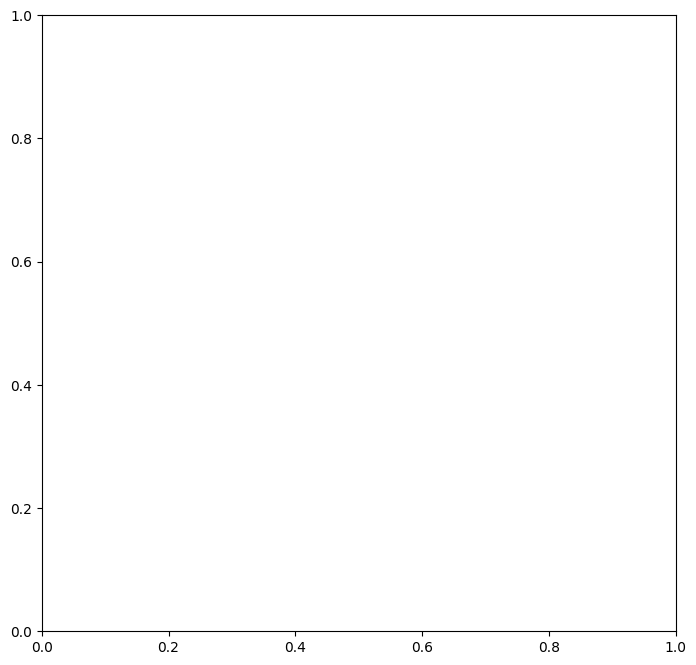

In [16]:
 #Visualizing the results
#set plot size
plt.figure(figsize = (18,8))

#set 1st subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

#renders cleanly
plt.show()

bjects=

In [59]:
#saving the model
#save weights
siamese_model.save('siamesemodel.h5')

In [60]:
# reload the model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [61]:
#make predictions from saved model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


array([[[4.6306782e-06],
        [9.9996525e-01],
        [1.2016005e-05],
        [9.9936986e-01],
        [2.5526488e-05],
        [1.3859334e-04],
        [6.3894590e-04],
        [1.2432353e-03],
        [9.9712938e-01],
        [9.2291454e-04],
        [9.9998033e-01],
        [1.7886277e-04],
        [9.9999809e-01],
        [1.0000000e+00],
        [2.3972249e-05],
        [9.9999654e-01]]], dtype=float32)

In [62]:
model.summary

<bound method Model.summary of <Functional name=Siamese, built=True>>

REAL TIME PREDICTIONS WITH OPENCV
1. setup verification images
2. build verify function
3. perform recognition in real time

In [63]:
#verification function
def verify(model, detection_threshold, verification_threshold):
    #build result array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocessing(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocessing(os.path.join('application_data', 'verification_images', image))
        
        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis =1)))
        results.append(result)
        
    
    #detection threshold - metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    #verification threshold - proportion of positive predictions/total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
        
    return results, verified

In [64]:
#OpenCV real time verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'),frame)
        #run verification
        results, verified = verify(model, 0.99, 0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━